# MSI2: Classificação de Caminhabilidade por Aprendizado de Máquina
Augusto Carvalho Porto Pereira - 2019054358

In [1]:
import pandas as pd
import numpy as np
import altair as alt
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import precision_score
from sklearn.model_selection import StratifiedKFold
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


## Tema: Caminhabilidade em Belo Horizonte

O objetivo deste trabalho é utilizar de algoritmos de Aprendizado de Máquina para calcular métricas de Walkability. Medidas de caminhabilidade buscam descrever, basicamente, sobre o incentivo e a viabilidade de deslocamento a pé nas cidades (especialmente metrópoles).

Os dados a serem utilizados aqui foram trabalhados a partir de dados disponíveis pela Prefeitura de Belo Horizonte no site [BH Map](https://bhmap.pbh.gov.br/v2/mapa/idebhgeo). Usando de informações como declividade, iluminação, atividade econômica e etc, buscaremos criar uma separação grosseira entre áreas boas e ruins para se trabalhar. A estimativa será grosseira pois a métrica de walkability é vista geralmente como um espectro, porém para os termos dessa disciplina (e para a monografia onde os resultados desse projeto serão aproveitados) uma separação binária é suficiente.

Iniciemos o tratamento dos dados:

In [2]:
fh = pd.read_csv("https://raw.githubusercontent.com/Augustonildo/walkability-belo-horizonte/main/Machine%20Learning/data-walkability-firsthalf.csv")
sh = pd.read_csv("https://raw.githubusercontent.com/Augustonildo/walkability-belo-horizonte/main/Machine%20Learning/data-walkability-secondhalf.csv")

df = pd.concat([fh,sh], axis=0)

df.set_index('id', inplace=True)
df['caminhavel'] = df['caminhavel'].astype('Int64')

df.head()

,media_declividade,praca_ou_parque,unidades_iluminacao,atividades_economicas,meio_fio,pavimentacao,class_viaria,caminhavel
id,,,,,,,,
4381,2.26,0,1,2,1,1,LOCAL,<NA>
4382,2.26,0,2,2,1,1,LOCAL,<NA>
4383,2.26,0,1,1,1,1,LOCAL,<NA>
4384,2.26,0,1,1,1,1,LOCAL,<NA>
10629,2.26,0,1,2,1,1,LOCAL,<NA>


In [3]:
df.describe()

,media_declividade,praca_ou_parque,unidades_iluminacao,atividades_economicas,meio_fio,pavimentacao,caminhavel
count,4.068581e+06,4.068581e+06,4.068581e+06,4.068581e+06,4.068581e+06,4.068581e+06,103447.0
mean,6.351334e+00,1.000912e-01,1.253010e+00,4.687247e+00,8.555767e-01,8.744285e-01,0.176854
std,5.150048e+00,3.001215e-01,1.150004e+00,1.240934e+01,3.515185e-01,3.313659e-01,0.381547
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,2.670000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,0.0
50%,5.622500e+00,0.000000e+00,1.000000e+00,2.000000e+00,1.000000e+00,1.000000e+00,0.0
75%,8.950000e+00,0.000000e+00,2.000000e+00,6.000000e+00,1.000000e+00,1.000000e+00,0.0
max,1.591900e+02,1.000000e+00,3.200000e+01,1.187000e+03,1.000000e+00,1.000000e+00,1.0


In [4]:
# alt.data_transformers.enable('default', max_rows=4068582) # Número total de dados

## Histograma das colunas de dados não binárias, para melhor visualização de suas concentrações
data_number_columns = df[['media_declividade','unidades_iluminacao','atividades_economicas']].copy()

# for column in data_number_columns:
  #chart = alt.Chart(data_number_columns).mark_bar().encode(x = column, y = 'count()')
  # chart.display()

In [5]:
df = pd.get_dummies(df)

df.head()

,media_declividade,praca_ou_parque,unidades_iluminacao,atividades_economicas,meio_fio,pavimentacao,caminhavel,class_viaria_ARTERIAL,class_viaria_COLETORA,class_viaria_LIGACAO REGIONAL,class_viaria_LOCAL,class_viaria_MISTA,class_viaria_VIA DE PEDESTRES
id,,,,,,,,,,,,,
4381,2.26,0,1,2,1,1,<NA>,0,0,0,1,0,0
4382,2.26,0,2,2,1,1,<NA>,0,0,0,1,0,0
4383,2.26,0,1,1,1,1,<NA>,0,0,0,1,0,0
4384,2.26,0,1,1,1,1,<NA>,0,0,0,1,0,0
10629,2.26,0,1,2,1,1,<NA>,0,0,0,1,0,0


### Z-Norm
Para os dados numéricos não binários acima, vamos realizar uma Z-normalização. O objetivo é que estes dados passem a ter média 0 e desvio padrão 1. A normalização corre como a fórmula a seguir:

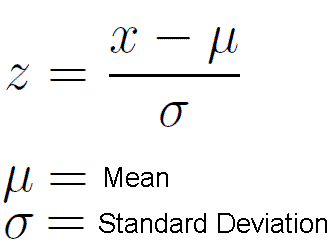

In [6]:
## Normalizando dados numéricos não binários:
std = data_number_columns.std(ddof=1)
data_number_columns=(data_number_columns - data_number_columns.mean()) / std #normalizando colunas
df[['media_declividade','unidades_iluminacao','atividades_economicas']] = data_number_columns

df.head()

,media_declividade,praca_ou_parque,unidades_iluminacao,atividades_economicas,meio_fio,pavimentacao,caminhavel,class_viaria_ARTERIAL,class_viaria_COLETORA,class_viaria_LIGACAO REGIONAL,class_viaria_LOCAL,class_viaria_MISTA,class_viaria_VIA DE PEDESTRES
id,,,,,,,,,,,,,
4381,-0.794426,0,-0.220008,-0.216550,1,1,<NA>,0,0,0,1,0,0
4382,-0.794426,0,0.649554,-0.216550,1,1,<NA>,0,0,0,1,0,0
4383,-0.794426,0,-0.220008,-0.297135,1,1,<NA>,0,0,0,1,0,0
4384,-0.794426,0,-0.220008,-0.297135,1,1,<NA>,0,0,0,1,0,0
10629,-0.794426,0,-0.220008,-0.216550,1,1,<NA>,0,0,0,1,0,0


In [7]:
# Correlação dos dados
correlation = (df
                .corr(numeric_only=True)
                .stack()
                .reset_index()
                .rename(columns={0: 'correlation', 'level_0': 'variable', 'level_1': 'variable2'}))
correlation['correlation_label'] = correlation['correlation'].map('{:.2f}'.format)

In [8]:
base = alt.Chart(correlation).encode(
    x='variable2:O',
    y='variable:O')

text = base.mark_text().encode(
    text='correlation_label',
    color=alt.condition(
        alt.datum.correlation > 0.5,
        alt.value('white'),
        alt.value('black')))

cor_plot = base.mark_rect().encode(
    color='correlation:Q').properties(width=800, height=600)

cor_plot + text

alt.LayerChart(...)

Acima, podemos perceber que as variáveis meio-fio e pavimentação são extremamente correlacionadas (quase 1.0), o que instintivamente faz sentido se pensarmos nas vias de Belo Horizonte. Vamos portanto remover uma das duas (arbitrariamente, pavimentação).

In [9]:
df.drop(['pavimentacao'], axis=1, inplace=True)

In [10]:
df.head()

,media_declividade,praca_ou_parque,unidades_iluminacao,atividades_economicas,meio_fio,caminhavel,class_viaria_ARTERIAL,class_viaria_COLETORA,class_viaria_LIGACAO REGIONAL,class_viaria_LOCAL,class_viaria_MISTA,class_viaria_VIA DE PEDESTRES
id,,,,,,,,,,,,
4381,-0.794426,0,-0.220008,-0.216550,1,<NA>,0,0,0,1,0,0
4382,-0.794426,0,0.649554,-0.216550,1,<NA>,0,0,0,1,0,0
4383,-0.794426,0,-0.220008,-0.297135,1,<NA>,0,0,0,1,0,0
4384,-0.794426,0,-0.220008,-0.297135,1,<NA>,0,0,0,1,0,0
10629,-0.794426,0,-0.220008,-0.216550,1,<NA>,0,0,0,1,0,0


### Transformações

In [11]:
#Aqui estão separadas somente aquelas colunas em que há uma label de caminhabilidade.
labeled_df = df[df['caminhavel'].notnull()].copy()
labeled_df.head()

,media_declividade,praca_ou_parque,unidades_iluminacao,atividades_economicas,meio_fio,caminhavel,class_viaria_ARTERIAL,class_viaria_COLETORA,class_viaria_LIGACAO REGIONAL,class_viaria_LOCAL,class_viaria_MISTA,class_viaria_VIA DE PEDESTRES
id,,,,,,,,,,,,
973644,-0.824523,1,1.519117,-0.055381,1,1,0,0,0,1,0,0
992394,-0.539574,1,1.519117,0.105788,1,1,0,0,0,1,0,0
998645,-0.539574,1,1.519117,0.186372,1,1,0,0,0,1,0,0
1298633,-0.905105,0,-1.089571,-0.377719,0,0,0,0,0,1,0,0
1298634,-0.905105,0,-1.089571,-0.377719,0,0,0,0,0,1,0,0


In [12]:
# Separando dado e label

X = labeled_df.drop(['caminhavel'], axis=1)
y = labeled_df['caminhavel']

In [13]:
# Pegando todos os dados, com ou sem label
Unlabeled_data = df.drop(['caminhavel'], axis=1)

In [14]:
SPLITS_NUMBER = 5

def classifier(model, X, y):
  kfold = StratifiedKFold(n_splits=SPLITS_NUMBER, shuffle=True, random_state=14)
  sets = kfold.split(X,y)
  score = 0
  for size,(train_index,test_index) in enumerate(sets):
    train_data = X.iloc[train_index]
    train_label = y.iloc[train_index]
    test_data = X.iloc[test_index]
    test_label = y.iloc[test_index]

    model.fit(train_data, train_label)
    prediction = model.predict(test_data)
    score += precision_score(test_label, prediction, average='macro', labels=np.unique(prediction))
  return score/SPLITS_NUMBER, model.predict(Unlabeled_data)

In [15]:
aval_df = pd.DataFrame(
    [
        ['Decision Tree Classifier',DecisionTreeClassifier(max_depth=5), 0],
        ['Random Forest Tree Classifier',RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), 0],
        ['Gaussian Naïve Bayes',GaussianNB(), 0],
        ['AdaBoost',AdaBoostClassifier(), 0],
        ['Neural Networks',MLPClassifier(alpha=1, max_iter=1000), 0],
        ['Linear SVM', SVC(kernel="linear", C=0.025), 0],
        ['K-Nearest Neighbors', KNeighborsClassifier(2), 0],
    ],
    columns= ['Name', 'Model', 'Score']
)

In [16]:
from datetime import datetime, timezone

labeled_final_lists = []

for index, row in aval_df.iterrows():
  startTime = datetime.now(tz=timezone.utc).timestamp()
  result, prediction = classifier(row['Model'], X, y)
  print(row['Name'], ': ', result)
  print("Tempo de execução (em segundos): ", datetime.now(tz=timezone.utc).timestamp()  - startTime, "\n")
  aval_df.at[index, 'Score'] = result
  labeled_final_lists.append(prediction)

Decision Tree Classifier :  0.9949429552430862
Time spent (in ms):  2.1658430099487305
Random Forest Tree Classifier :  0.982525862541085
Time spent (in ms):  8.073669910430908
Gaussian Naïve Bayes :  0.8179404239777076
Time spent (in ms):  2.2607548236846924
AdaBoost :  0.997534783758289
Time spent (in ms):  44.17429304122925
Neural Networks :  0.9835290273592058
Time spent (in ms):  62.759138107299805
Linear SVM :  0.991537599799029
Time spent (in ms):  330.41909098625183
K-Nearest Neighbors :  0.9998416927634072
Time spent (in ms):  497.73630595207214


## Visualizando os resultados

Com cada um dos classificadores testado, podemos escolher a previsão feita por qualquer um deles e visualizar os valores definidos em um software de visualização, para enxergarmos como o modelo visualiza a caminhabilidade com base nos dados de teste.

Agora, vamos olhar somente para o modelo que teve o melhor resultado, porém podemos fazer o mesmo alterando a variável abaixo.

In [18]:
# Index do classificador escolhido (na mesma ordem usada anteriormente)
CHOSEN_CLASSIFIER_INDEX = 6 # K-Nearest Neighbors :  0.9998416927634072

In [19]:
df['previsao_caminhabilidade'] = labeled_final_lists[CHOSEN_CLASSIFIER_INDEX].astype(int)
df

,media_declividade,praca_ou_parque,unidades_iluminacao,atividades_economicas,meio_fio,caminhavel,class_viaria_ARTERIAL,class_viaria_COLETORA,class_viaria_LIGACAO REGIONAL,class_viaria_LOCAL,class_viaria_MISTA,class_viaria_VIA DE PEDESTRES,previsao_caminhabilidade
id,,,,,,,,,,,,,
4381,-0.794426,0,-0.220008,-0.216550,1,<NA>,0,0,0,1,0,0,1
4382,-0.794426,0,0.649554,-0.216550,1,<NA>,0,0,0,1,0,0,1
4383,-0.794426,0,-0.220008,-0.297135,1,<NA>,0,0,0,1,0,0,1
4384,-0.794426,0,-0.220008,-0.297135,1,<NA>,0,0,0,1,0,0,1
10629,-0.794426,0,-0.220008,-0.216550,1,<NA>,0,0,0,1,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
27062352,-1.233257,0,-1.089571,-0.377719,0,<NA>,0,0,0,0,0,0,0
27062353,-1.233257,0,-1.089571,-0.377719,0,<NA>,0,0,0,0,0,0,0
27062354,-1.233257,0,-1.089571,-0.377719,0,<NA>,0,0,0,0,0,0,0


In [20]:
# Baixando o resultado como csv para visualizar no QGIS
df[['previsao_caminhabilidade']].to_csv('resultado.csv')